# Recommendations with IBM

In this notebook, a recommendation machine is provided to recomend articles to the students using real data from the IBM Watson Studio platform. 
a number of different methods for making recommendations that can be used for different situations is listed in the following table of contents

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>


In [5]:
# import libraries and read data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data\\user-item-interactions.csv')
df_content = pd.read_csv('data\\articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

This section gives some insight into the data's descriptive statistics.

`1.` Checking the geometry of the data frame and data statistics to become familiar with the data. Checking for duplicates and nulls. What is the distribution of how many articles in the dataset a user interacts with?

In [6]:
# an idea of the df data set
print(df.shape, end='\n\n$$\n\n')
print(df.columns, end='\n\n$$\n\n')
print(df.info(), end='\n\n$$\n\n')
print(df.describe(), end='\n\n$$\n\n')
print('null\n',df.isnull().sum(), end='\n\n$$\n\n')
print('duplication\n',df.duplicated().sum(), end='\n\n$$\n\n')
print(df.head())

(45993, 3)

$$

Index(['article_id', 'title', 'email'], dtype='object')

$$

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  45993 non-null  float64
 1   title       45993 non-null  object 
 2   email       45976 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB
None

$$

         article_id
count  45993.000000
mean     908.846477
std      486.647866
min        0.000000
25%      460.000000
50%     1151.000000
75%     1336.000000
max     1444.000000

$$

null
 article_id     0
title          0
email         17
dtype: int64

$$

duplication
 12311

$$

   article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classifica

In [7]:
# an idea of the df_content data set
print(df_content.shape, end='\n\n$$\n\n')
print(df_content.columns, end='\n\n$$\n\n')
print(df_content.info(), end='\n\n$$\n\n')
print(df_content.describe(), end='\n\n$$\n\n')
print('null\n',df_content.isnull().sum(), end='\n\n$$\n\n')
print('duplication\n',df_content.duplicated().sum(), end='\n\n$$\n\n')
print('duplication id\n',df_content.article_id.duplicated().sum(), end='\n\n$$\n\n')
print(df_content.head())

(1056, 5)

$$

Index(['doc_body', 'doc_description', 'doc_full_name', 'doc_status',
       'article_id'],
      dtype='object')

$$

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB
None

$$

        article_id
count  1056.000000
mean    523.913826
std     303.480641
min       0.000000
25%     260.750000
50%     523.500000
75%     786.250000
max    1050.000000

$$

null
 doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

$$

duplication
 0

$$

duplication id
 5

$$

                                

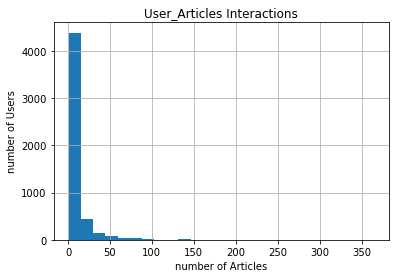

In [8]:
# data visualization, number of article views per user is displayed by histogram
df['email'].value_counts().hist(bins = 25)
plt.title('User_Articles Interactions')
plt.xlabel('number of Articles')
plt.ylabel('number of Users')
plt.show()

In [9]:
# 50% of individuals interact with ____ number of articles or fewer.
median_val = df.email.value_counts().median()

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = df.email.value_counts().max()

print('median_val:\n', median_val, '\n\nmax_views_by_user:\n',max_views_by_user )

median_val:
 3.0 

max_views_by_user:
 364


In [10]:
# The number of unique articles that have at least one interaction
unique_articles = df.article_id.value_counts().shape[0]

# The number of unique articles on the IBM platform
total_articles = df_content.article_id.value_counts().shape[0]

# The number of unique users
unique_users = df.email.value_counts().shape[0]

# The number of user-article interactions
user_article_interactions = df.article_id.value_counts().sum()

print('unique_articles:\n',unique_articles,'\n\ntotal_articles:\n',total_articles,\
      '\n\nunique_users:\n',unique_users,'\n\nuser_article_interactions:\n',user_article_interactions)

unique_articles:
 714 

total_articles:
 1051 

unique_users:
 5148 

user_article_interactions:
 45993


In [11]:
# The most viewed article in the dataset as a string with one value following the decimal 
a = df.article_id.value_counts().index[0]
most_viewed_article_id  = '1429.0'

# The most viewed article in the dataset was viewed how many times?
max_views = df.article_id.value_counts().max()

print('most_viewed_article_id:\n',a ,most_viewed_article_id,'\n\nmax_views:\n', max_views)

most_viewed_article_id:
 1429.0 1429.0 

max_views:
 937


In [12]:
# chekning the results from the cells above,

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test the dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [13]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df,column='email'):
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df[column]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded


In [14]:
email_encoded = email_mapper(df,'email')
del df['email']
df['user_id'] = email_encoded

# show header
df.head(20)

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
5,1432.0,visualize data with the matplotlib library,6
6,1429.0,use deep learning for image classification,7
7,593.0,upload files to ibm data science experience us...,8
8,1314.0,healthcare python streaming application demo,9
9,1185.0,classify tumors with machine learning,10


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this data set, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` The function below returns the **n** top articles ordered with most interactions as the top. 

In [15]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.title.value_counts().index[0:n].tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.article_id.value_counts().index[0:n]
    top_articles_ids = [str(a_id) for a_id in top_articles]
 
    return top_articles_ids # Return the top article ids

In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [17]:
# Test the function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of the three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The function below is used to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** appears in each **row** once.


* Each **article** shows up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [18]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df,index='user_id',column='article_id'):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_article = pd.get_dummies(df.set_index(index)[column].astype(str)).max(level=0).sort_index()

    
    return user_article # return the user_item matrix 


In [19]:
user_item = create_user_item_matrix(df,index='user_id',column='article_id')
print(user_item.shape[0])
print(user_item.shape[1])
print(user_item.sum(axis=1)[1])

5149
714
36


In [20]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Function below takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 


In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    product = user_item.loc[user_id].dot(user_item.T).tolist()
    
    dict={}
    i=1
    for value in product:
        dict[i]=value
        i+=1
        
    dict_sort ={k: v for k, v in sorted(dict.items(), key=lambda item: item[1], reverse=True)}
    del dict_sort[user_id]
    most_similar_users = list(dict_sort.keys())
       
    return most_similar_users # return a list of the users in order from most to least similar

In [22]:
# a spot check of the function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  The functions below returns the articles you would recommend to each user. 

In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for value in article_ids:
        a = list(df[df['article_id']==float(value)]['title'])[0]
        article_names.append(a)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id][user_item.loc[user_id]==1].index.tolist()
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id, user_item=user_item)
    seen_articles = get_user_articles(user_id, user_item=user_item, df= df)[0]
    recs= []
    for value in similar_users:
        article_id = get_user_articles(value, user_item=user_item, df= df)[0]
        for item in article_id:
            if item not in recs and item not in seen_articles and len(recs)<m:
                recs.append(item)
            else:
                break
    
    return recs # return your recommendations for this user_id

In [24]:
# Check Results
get_article_names(user_user_recs(1, 10, df=df)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 'the pandas data analysis library',
 'mapping points with folium',
 'a comparison of logistic regression and naive bayes ',
 'access mysql with python',
 'tidy up your jupyter notebooks with scripts',
 'analyze accident reports on amazon emr spark']

In [25]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20, user_item=user_item, df=df)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function which was provided earlier.

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    product = user_item.loc[user_id].dot(user_item.T).tolist()
    dict={}
    i=1
    for value in product:
        dict[i]=value
        i+=1 
    dict_sort ={k: v for k, v in sorted(dict.items(), key=lambda item: item[1], reverse=True)}
    
    for key, value in dict_sort.items():
        num_interactions = user_item.loc[key].sum()
        dict_sort[key]=value, num_interactions
    
    df2 = pd.DataFrame.from_dict(dict_sort, orient='index',columns=['similarity', 'num_interactions'])
    neighbors_df = df2.sort_values(['similarity','num_interactions'], axis=0, ascending=False)
    neighbors_df.drop(user_id , inplace=True)
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    neighbors_df = get_top_sorted_users(user_id, df=df, user_item=user_item)
    seen_articles = get_user_articles(user_id, user_item=user_item, df= df)[0]
    recs= []
    for similar_user in neighbors_df.index:
        articles = get_user_articles(similar_user, user_item=user_item, df= df)[0]
        dic = {}
        for article in articles:
            article_interaction = user_item[article].sum()
            dic[article]= article_interaction
            
        dic_sort = {k: v for k, v in sorted(dic.items(), key=lambda item: item[1],reverse=True)}
        aricles_sort = list(dic_sort.keys())
    
        for item in aricles_sort:
            if item not in recs and item not in seen_articles and len(recs)<m:
                recs.append(item)
            else:
                break
    rec_names = get_article_names(recs, df=df)          
    
    return recs, rec_names

In [27]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1429.0', '1314.0', '1271.0', '43.0', '1351.0', '1336.0', '1368.0', '151.0', '1338.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use deep learning for image classification', 'healthcare python streaming application demo', 'customer demographics and sales', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'learn basics about notebooks and apache spark', 'putting a human face on machine learning', 'jupyter notebook tutorial', 'ml optimization using cognitive assistant']


In [28]:
# Find the user that is most similar to user 1
# Find the 10th most similar user to user 131
# Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item).index[0]
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item).index[10]
print(user1_most_sim , user131_10th_sim)

3933 242


In [29]:
# Tests with a dictionary of results
# Dictionary Test Here

sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

One way is to use the function get_top_article_ids(10), so that the new user receive the top 10 of the most interacted articles among the whole user base. It is not the best option, since we do not specify the recommendations for each user. It is just a general indication. Another solution can be the use of a knowledge based or content based recommendation engines to solve the cold start problem.

`7.` In the following get_top_article_ids(10) is used to provide the top 10 recommended articles for the a new user.

In [30]:
new_user = '0.0'

# a list of the top 10 article ids you would give to new user

new_user_recs = get_top_article_ids(10, df=df)
new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [31]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, a matrix factorization makes article recommendations to the users on the IBM Watson Studio platform.

`1.` a **user_item** matrix has been already created above in **Part III**. This first part here will just require that you run the cells to get things set up for the rest of **Part IV** of the notebook. 

In [32]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [33]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) is used on the user-item matrix.

In [34]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)
print(u.shape,s.shape,vt.shape)

(5149, 5149) (714,) (714, 714)


Since there is no NaN values in the user_item_matrix, we don't need FunkSVD. Also it does not include any rating values and it is a binary matrix including just 0 and 1. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

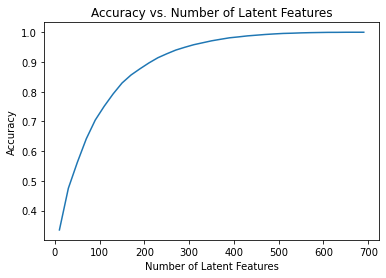

In [35]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many latent features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Here we try to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [36]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    # User-item matrix of the training dataframe
    user_item_train = create_user_item_matrix(df_train,index='user_id',column='article_id')
    user_item_test = create_user_item_matrix(df_test,index='user_id',column='article_id')
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [37]:
print('articles of the test set we can make predictions about:')
print(len(np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique())))

print('articles of the test set we cant make predictions about:')
print(len(df_test.article_id.unique()) - len(np.intersect1d(df_train.article_id.unique(),df_test.article_id.unique())))

print('users of the test set we can make predictions about:')
print(len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique())))

print('users of the test set we cant make predictions about:')
print(len(df_test.user_id.unique()) - len(np.intersect1d(df_train.user_id.unique(),df_test.user_id.unique())))

articles of the test set we can make predictions about:
574
articles of the test set we cant make predictions about:
0
users of the test set we can make predictions about:
20
users of the test set we cant make predictions about:
662


In [38]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [39]:
# fit SVD on the user_item_train matrix
# train articles and user_ids
train_idx = np.array(user_item_train.index)
train_arts = np.array(user_item_train.columns)

# user_ids and articles in both training and test set
test_user_subset = np.intersect1d(test_idx,train_idx)
test_articles_subset = np.intersect1d(test_arts,train_arts)

# find user_ids and article_ids location
train_indexes = np.where(np.in1d(train_idx, test_user_subset))[0]
train_articles = np.where(np.in1d(train_arts, test_articles_subset))[0]

# find the location in the test matrix of the test subset
test_indexes = np.where(np.in1d(test_idx, test_user_subset))[0]

In [40]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
print(u.shape,s.shape,vt.shape)

(5149, 5149) (714,) (714, 714)


In [41]:
# FIND SUBSET OF USER_ITEM MATRIX CONTAINING ONLY USER AND ARTICLES THAT ARE SHARED BY TRAIN AND TEST SET

user_item_test_subset = user_item_test.iloc[test_indexes,:]
user_item_train_subset = user_item_train.iloc[train_indexes,train_articles]

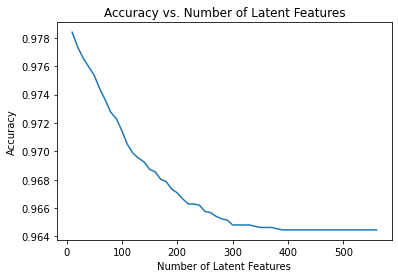

In [42]:
num_latent_feats = np.arange(10,570,10)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[train_indexes,:], vt_train_k[:,train_articles]
    
    # take dot product
    user_item_test_subset_est = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_test_subset_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


n_interactions_subset = user_item_test_subset.shape[0]*user_item_test_subset.shape[1]
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/n_interactions_subset);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy VS Number of Latent Features');

The accuracy associated to the training data tends to increase towards one hundred percent as the latent features increase. In the other hand, the accuracy associated with the test data tends to decrease as the latent features increase. This is overfitting. This difference could be due to the lack of users shared between the testing and training datasers, which might not be sufficient data to compare predictions to actual values. Another explanation can be the binary nature (ones and zeros) of the matrix, which is imbalanced compared to the values associated to a rating system.

As an alternative , we could use an A/B test to measure the effectiveness of a rank based recommendation system against the matrix recommendation system. In this test, we would separate users using cookies into equal number groups. Group A would use the rank based recommendations while group B would use the matrix based recommendations.